#  Множественное тестирование гипотез

Тестировании гипотез о долях, корректировка Бенджамини-Хохберга, корректировка методом Холма

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from scipy import stats as sts
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('ggplot')
%matplotlib inline

В файле `basketball.tsv` лежит [статистика о штрафных бросках в играх в Баскетбол, собранная с сайта ESPN.com](https://www.kaggle.com/sebastianmantey/nba-free-throws)

In [2]:
df = pd.read_csv('C:\\Users\\ksenkys\\basketball.tsv', sep='\t')
print(df.shape)
df.head( )

(618019, 13)


,end_result,game,game_id,period,play,player,playoffs,score,season,shot_made,time,command,is_home
0,106 - 114,PHX - LAL,261031013.0,1.0,Andrew Bynum makes free throw 1 of 2,Andrew Bynum,regular,0 - 1,2006 - 2007,1,11:45,LAL,False
1,106 - 114,PHX - LAL,261031013.0,1.0,Andrew Bynum makes free throw 2 of 2,Andrew Bynum,regular,0 - 2,2006 - 2007,1,11:45,LAL,False
2,106 - 114,PHX - LAL,261031013.0,1.0,Andrew Bynum makes free throw 1 of 2,Andrew Bynum,regular,18 - 12,2006 - 2007,1,7:26,LAL,False
3,106 - 114,PHX - LAL,261031013.0,1.0,Andrew Bynum misses free throw 2 of 2,Andrew Bynum,regular,18 - 12,2006 - 2007,0,7:26,LAL,False
4,106 - 114,PHX - LAL,261031013.0,1.0,Shawn Marion makes free throw 1 of 1,Shawn Marion,regular,21 - 12,2006 - 2007,1,7:18,PHX,True


__Описание колонок:__

* `end_result` - результат игры
* `game` - какие команды играли, команда справа - хозяин площадки
* `game_id` - уникальный id игры
* `period` - период
* `player` - имя игрока
* `playoff` - тип игры
* `score` - счёт после броска 
* `season` - сезон игры
* `shot_made` - попал или не попал в кольцо при броске 
* `time` - время броска 
* `command` - предполагаемая команда игрока (колонка рассчитана по датасету)
* `is_home` - домашний матч или в гостях

# 1. Данные

Посмотрим на данные.

Количество __уникальных игр__, сыгранных в течение сезона (`ans1`). Количество __уникальных игроков__ (`ans2`).

In [4]:
ans1 = df.game_id.nunique()
ans2 = df.player.nunique()
ans1, ans2

(12874, 1098)

### Доля попаданий

Подсчитаем по каждому игроку статистику, связанную с тем, как часто он попадет в корзину при бросках:

- __Долю попаданий__ в корзину среди его бросков, $\hat{p}$
- __Число бросков__, которое было сделано игроком, $n$

Среди игроков, которые сделали более ста бросков, найдем самого успешного. Запишем его в переменную `ans3`.

In [6]:
shooting = df.groupby(["player"])["shot_made"].agg(["size", "mean"])
shooting = shooting.rename(columns = {"size": "n", "mean": "percentage"})

shooting = shooting[shooting.n > 100]
ans3 = shooting.sort_values('percentage', ascending=False).reset_index()['player'][0]
shooting.head()

,n,percentage
player,,
A.J. Price,282,0.748227
Aaron Brooks,1109,0.836790
Aaron Gordon,254,0.681102
Aaron Gray,339,0.557522
Acie Law,229,0.781659


### Медиана и коэффициент асимметрии

Найдем медиану распределения, запишем её в переменную `ans4`. Найдем значение коэффициента асимметрии, запишем его в переменную `ans5`. Распределение этой переменной оказывается скошенным.

Построим гистограмму для доли попаданий игроков, нарисуем на ней медиану. 

(0.7568223240234471, -1.037195664364386)

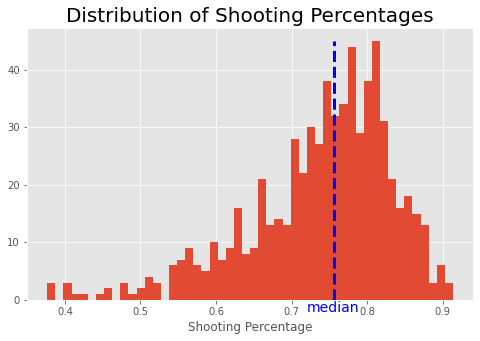

In [8]:
ans4 = shooting.percentage.median()
ans5 = sts.skew(shooting.percentage.values)

shooting.percentage.hist(bins=50, figsize=(8,5))

plt.title("Distribution of Shooting Percentages", fontsize=20)
plt.xlabel("Shooting Percentage")

plt.vlines(x=ans4, ymin=0, ymax=45, color="blue", linestyle="--", lw=3)
plt.text(x=0.72, y=-2, s="median", color="blue", fontsize=14);
ans4, ans5

Распределение доли успешных бросков имеет отрицательную ассиметрию, распределение похоже на левостороннее номральное распределение. Большинство игроков совершают от 70 до 80% успешных бросков. Лучший процент попадания около 90%, худший процент попаданий около 50%. Медиана расположена примерно на 75,5% успешных бросков.

# 2. Сравнение статистики игр дома и в гостях

Проанализируем, как часто игроки попадают в корзину дома и как часто в гостях. Подсчитаем доли попаданий в корзину в гостях и дома для всех ироков из выборки. Если для какого-то игрока оказывается, что он всегда играл только дома/только в гостях, удалим его из выборки.

Проверим гипотезу о равенстве этих долей для каждого игрока против двусторонней альтернативы. Число гипотез, которые отклоняются на уровне значимости $5\%$,  запишем в переменную `ans6`. 

In [4]:
df1 = df[df.is_home].groupby('player')["shot_made"].agg(['sum', "size", "mean"])
df1 = df1.rename(columns = {'sum': 'shot_home', "size": "n_home", "mean": "p_home"})

df2 = df[~df.is_home].groupby('player')["shot_made"].agg(['sum', "size", "mean"])
df2 = df2.rename(columns = {'sum': 'shot_guest', "size": "n_guest", "mean": "p_guest"})

dff = df1.join(df2)
dff

,shot_home,n_home,p_home,shot_guest,n_guest,p_guest
player,,,,,,
A.J. Price,96,132,0.727273,115.0,150.0,0.766667
Aaron Brooks,454,537,0.845438,474.0,572.0,0.828671
Aaron Gordon,81,120,0.675000,92.0,134.0,0.686567
Aaron Gray,98,192,0.510417,91.0,147.0,0.619048
Aaron Williams,12,14,0.857143,20.0,26.0,0.769231
...,...,...,...,...,...,...
Zach LaVine,150,183,0.819672,160.0,197.0,0.812183
Zach Randolph,1239,1655,0.748640,1374.0,1760.0,0.780682
Zaza Pachulia,744,1017,0.731563,789.0,1021.0,0.772772


In [5]:
dff['diff'] = dff['p_home'] - dff['p_guest']

P = (dff['shot_home'] + dff['shot_guest'])/(dff['n_home'] + dff['n_guest'])

dff['diff_std'] = np.sqrt(P*(1 - P)*(1/dff['n_home'] + 1/dff['n_guest']))

dff['z_obs'] = -1*np.abs(dff['diff']/dff['diff_std'])
dff['pvalue'] = 2*sts.norm.cdf(dff['z_obs']) 

print(dff.shape)
dff = dff.dropna()
print(dff.shape)
ans6 = (dff.pvalue < 0.05).sum()

dff.head()

(1086, 10)
(1023, 10)


,shot_home,n_home,p_home,shot_guest,n_guest,p_guest,diff,diff_std,z_obs,pvalue
player,,,,,,,,,,
A.J. Price,96,132,0.727273,115.0,150.0,0.766667,-0.039394,0.051798,-0.760530,0.446938
Aaron Brooks,454,537,0.845438,474.0,572.0,0.828671,0.016766,0.022206,-0.755048,0.450220
Aaron Gordon,81,120,0.675000,92.0,134.0,0.686567,-0.011567,0.058574,-0.197479,0.843453
Aaron Gray,98,192,0.510417,91.0,147.0,0.619048,-0.108631,0.054434,-1.995658,0.045971
Aaron Williams,12,14,0.857143,20.0,26.0,0.769231,0.087912,0.132599,-0.662994,0.507335


In [6]:
ans6

70

### Введем коррекции уровня значимости, чтобы он не выходил из-под контроля из-за множественного тестирования

Коррекция с помощью метода Холма. Запишем число гипотез, которые были отклонены на уровне значимости $5\%$, в переменную `ans7`.

In [7]:
from statsmodels.sandbox.stats.multicomp import multipletests 

reject, p_corrected, a1, a2 = multipletests(dff.pvalue.values, alpha = 0.05, method = 'holm') 
dff['pholm'] = p_corrected
ans7 = (dff.pholm < 0.05).sum()
ans7

0

Введите коррекцию с помощью метода Бенжамини-Хохберга. Запишите число гипотез, которые были отклонены на уровне значимости $5\%$, в переменную `ans8`.

In [8]:
reject, p_corrected, a1, a2 = multipletests(dff.pvalue.values, alpha = 0.05, method = 'fdr_bh') 
dff['pbh'] = p_corrected
ans8 = (dff.pbh < 0.05).sum()
ans8

0

Когда мы не вводили корректировку, уровень значимости выходил из-под контроля, по факту он был не 5%, а увеличивался с количеством тестируемых гипотез. Затем мы начали контролировать вероятность ошибки первого рода (вероятность отвергнуть гипотезу которая на самом деле верна), и стали отвергать гораздо меньше гипотез ( 0 вместо 70).

# 3. Динамика колебаний доли упсешных бросков


В наших данных есть несколько сезонов. Постройте гистограмму с распределением числа игр по каждому году. Видна ли на гистограмме [аномалия, произошедшая в $2011$ году?](https://en.wikipedia.org/wiki/2011_NBA_lockout) 

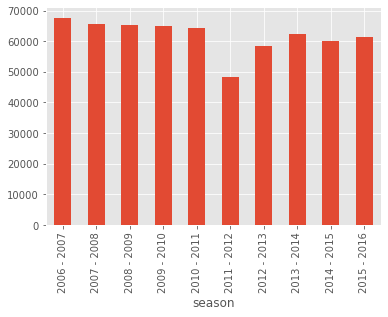

In [32]:
df.groupby('season')['game'].count().plot(kind='bar');

- Посчитаем для каждого игрока по каждому сезону долю попаданий в кольцо и количество сделанных бросков. 

In [33]:
shooting_per_season = df.groupby(['player', 'season'])['shot_made'].agg(['mean', 'size'])
shooting_per_season

mean  size
player             season                     
A.J. Price         2009 - 2010  0.800000    75
                   2010 - 2011  0.692308    91
                   2011 - 2012  0.800000    35
                   2012 - 2013  0.790323    62
                   2013 - 2014  0.000000     2
...                                  ...   ...
Zydrunas Ilgauskas 2006 - 2007  0.815385   260
                   2007 - 2008  0.799283   279
                   2008 - 2009  0.772947   207
                   2009 - 2010  0.740385   104
                   2010 - 2011  0.769231    52

[4526 rows x 2 columns]

- Оставим в данных только те строки, где было сделано как минимум сто бросков. Удалим колонку с количеством сделанных бросков. 
- Методом `unstack("player")` вытащим индексы, отвечающие в группировке за игроков в названия столбцов. Методом `droplevel()` удалим все лишние заголовки таблицы.

In [34]:
shooting_per_season = shooting_per_season[shooting_per_season['size'] >= 100]
shooting_per_season = shooting_per_season.drop('size', axis=1).unstack('player')
shooting_per_season.head(1)

mean                                                      \
player      Aaron Brooks Aaron Gordon Adam Morrison Al Harrington Al Horford   
season                                                                         
2006 - 2007          NaN          NaN      0.716867        0.6875        NaN   

                                                                               \
player      Al Jefferson Al Thornton Al-Farouq Aminu Alan Anderson Alec Burks   
season                                                                          
2006 - 2007     0.681356         NaN             NaN           NaN        NaN   

             ...                                                   \
player       ... Willie Cauley-Stein Willie Green Wilson Chandler   
season       ...                                                    
2006 - 2007  ...                 NaN     0.666667             NaN   

                                                                          \
player      Xavier Henry  Yao Ming Yi Jianlian Zach LaVine Zach Randolph   
season                                                                     
2006 - 2007          NaN  0.868476         NaN         NaN      0.820513   

                                              
player      Zaza Pachulia Zydrunas Ilgauskas  
season                                        
2006 - 2007      0.787466           0.815385  

[1 rows x 538 columns]

In [35]:
shooting_per_season.columns = shooting_per_season.columns.droplevel()
shooting_per_season.head(1)

player,Aaron Brooks,Aaron Gordon,Adam Morrison,Al Harrington,Al Horford,Al Jefferson,Al Thornton,Al-Farouq Aminu,Alan Anderson,Alec Burks,...,Willie Cauley-Stein,Willie Green,Wilson Chandler,Xavier Henry,Yao Ming,Yi Jianlian,Zach LaVine,Zach Randolph,Zaza Pachulia,Zydrunas Ilgauskas
season,,,,,,,,,,,,,,,,,,,,,
2006 - 2007,NaN,NaN,0.716867,0.6875,NaN,0.681356,NaN,NaN,NaN,NaN,...,NaN,0.666667,NaN,NaN,0.868476,NaN,NaN,0.820513,0.787466,0.815385


- Удалим из данных всех игроков, у которых пропущена статистика хотя бы по одному сезону.

In [36]:
shooting_per_season = shooting_per_season.dropna(axis=1)
shooting_per_season.head(1)

player,Al Jefferson,Andre Iguodala,Carmelo Anthony,Chris Bosh,Chris Paul,Deron Williams,Devin Harris,Dirk Nowitzki,Dwight Howard,Dwyane Wade,...,Manu Ginobili,Pau Gasol,Paul Millsap,Rudy Gay,Tim Duncan,Tony Allen,Tony Parker,Tyson Chandler,Zach Randolph,Zaza Pachulia
season,,,,,,,,,,,,,,,,,,,,,
2006 - 2007,0.681356,0.820327,0.806344,0.78479,0.816901,0.771883,0.817857,0.89661,0.576102,0.796364,...,0.855372,0.743655,0.672566,0.727273,0.638028,0.783582,0.758772,0.532663,0.820513,0.787466


Посчтитаем для всех игроков __стандартное отклонение их доли попаданий__. 

In [37]:
shooting_std = shooting_per_season.std()
shooting_std

player
Al Jefferson         0.044703
Andre Iguodala       0.086967
Carmelo Anthony      0.022007
Chris Bosh           0.020911
Chris Paul           0.027927
Deron Williams       0.030991
Devin Harris         0.047734
Dirk Nowitzki        0.016183
Dwight Howard        0.051989
Dwyane Wade          0.020733
Jamal Crawford       0.027020
Jarrett Jack         0.019644
Joe Johnson          0.027987
Kevin Martin         0.015665
LaMarcus Aldridge    0.040264
LeBron James         0.025669
Luol Deng            0.014586
Manu Ginobili        0.050102
Pau Gasol            0.033607
Paul Millsap         0.041012
Rudy Gay             0.036775
Tim Duncan           0.045220
Tony Allen           0.059138
Tony Parker          0.030896
Tyson Chandler       0.067176
Zach Randolph        0.047434
Zaza Pachulia        0.053400
dtype: float64

In [38]:
shooting_std = pd.DataFrame({"std": shooting_std})
shooting_std.sort_values(by="std").head(10)

,std
player,
Luol Deng,0.014586
Kevin Martin,0.015665
Dirk Nowitzki,0.016183
Jarrett Jack,0.019644
Dwyane Wade,0.020733
Chris Bosh,0.020911
Carmelo Anthony,0.022007
LeBron James,0.025669
Jamal Crawford,0.027020


Построим для $3$ самых непредсказуемых игроков и для трёх самых предсказуемых игроков динамику доли их попаданий по сезонам (по оси $x$ сезоны, по оси $y$ доля попаданий). 

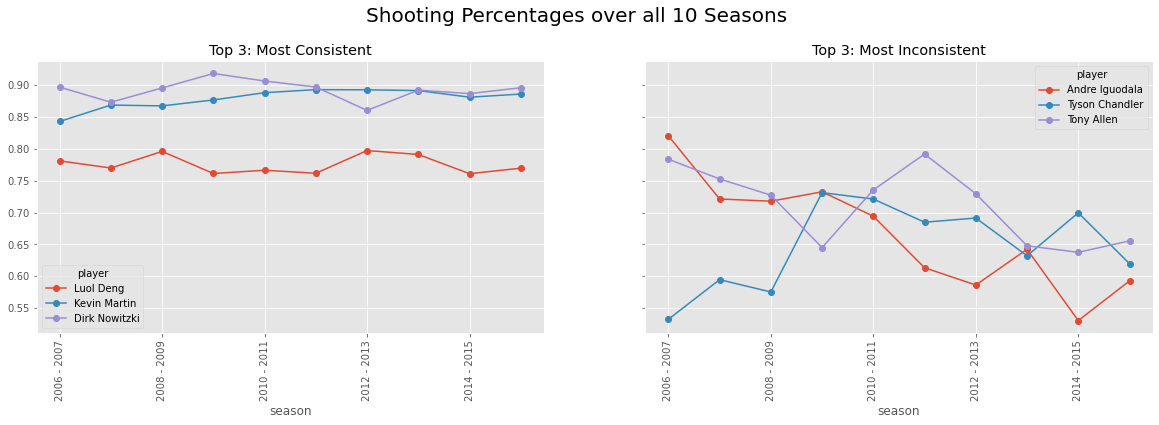

In [39]:
most_inconsistent = shooting_std.sort_values(by='std', ascending = False).head(3).index
most_consistent = shooting_std.sort_values(by='std').head(3).index

fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (20,5), sharey = True)

ax1 = shooting_per_season[most_consistent].plot(marker='o', rot=90, ax=ax[0], title='Top 3: Most Consistent')
ax2 = shooting_per_season[most_inconsistent].plot(marker='o', rot = 90, ax=ax[1], title='Top 3: Most Inconsistent')

plt.suptitle("Shooting Percentages over all 10 Seasons", y=1.03, fontsize=20);

# 4. Когда вероятность попасть выше


__Гипотеза:__

> Если мы попали в корзину, сделав первый штрафной бросок, вероятность попасть при втором штрафном выше, чем если бы мы промахнулись.

Проверим эту гипотезу. 

- Создадим в исходной таблице колонку `shot_made_previous` методом `shift()`. В ней будет записан результат предыдущего броска. Данные отсортированы по времени.
- Извлечём из данных в таблицу `winner_effect` все строки, где в колонке `play` находится одна из записей: `"2 of 2", "2 of 3", "3 of 3"`. Каждая из них означает, что предыдущий бросок был сделан успешно. Этот же срез выбросит из таблицы все строки, где сдвиг, сделанный в предыдущем пункте, привёл к появлению некорректных записей.  

In [41]:
df["shot_made_previous"] = df.shot_made.shift()
df

,end_result,game,game_id,period,play,player,playoffs,score,season,shot_made,time,command,is_home,shot_made_previous
0,106 - 114,PHX - LAL,261031013.0,1.0,Andrew Bynum makes free throw 1 of 2,Andrew Bynum,regular,0 - 1,2006 - 2007,1,11:45,LAL,False,NaN
1,106 - 114,PHX - LAL,261031013.0,1.0,Andrew Bynum makes free throw 2 of 2,Andrew Bynum,regular,0 - 2,2006 - 2007,1,11:45,LAL,False,1.0
2,106 - 114,PHX - LAL,261031013.0,1.0,Andrew Bynum makes free throw 1 of 2,Andrew Bynum,regular,18 - 12,2006 - 2007,1,7:26,LAL,False,1.0
3,106 - 114,PHX - LAL,261031013.0,1.0,Andrew Bynum misses free throw 2 of 2,Andrew Bynum,regular,18 - 12,2006 - 2007,0,7:26,LAL,False,1.0
4,106 - 114,PHX - LAL,261031013.0,1.0,Shawn Marion makes free throw 1 of 1,Shawn Marion,regular,21 - 12,2006 - 2007,1,7:18,PHX,True,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
618014,104 - 118,DAL - OKC,400874368.0,4.0,Randy Foye makes free throw 1 of 2,Randy Foye,playoffs,103 - 116,2015 - 2016,1,0:53,OKC,False,1.0
618015,104 - 118,DAL - OKC,400874368.0,4.0,Randy Foye makes free throw 2 of 2,Randy Foye,playoffs,103 - 117,2015 - 2016,1,0:53,OKC,False,1.0
618016,104 - 118,DAL - OKC,400874368.0,4.0,Kevin Durant makes technical free throw,Kevin Durant,playoffs,103 - 118,2015 - 2016,1,0:27,OKC,False,1.0
618017,104 - 118,DAL - OKC,400874368.0,4.0,Dwight Powell misses free throw 1 of 2,Dwight Powell,playoffs,103 - 118,2015 - 2016,0,0:26,DAL,True,1.0


In [42]:
winner_effect = df[(df.play.str.contains("2 of 2")) | \
                   (df.play.str.contains("2 of 3")) | 
                   (df.play.str.contains("3 of 3"))]
winner_effect.head(3)

,end_result,game,game_id,period,play,player,playoffs,score,season,shot_made,time,command,is_home,shot_made_previous
1,106 - 114,PHX - LAL,261031013.0,1.0,Andrew Bynum makes free throw 2 of 2,Andrew Bynum,regular,0 - 2,2006 - 2007,1,11:45,LAL,False,1.0
3,106 - 114,PHX - LAL,261031013.0,1.0,Andrew Bynum misses free throw 2 of 2,Andrew Bynum,regular,18 - 12,2006 - 2007,0,7:26,LAL,False,1.0
6,106 - 114,PHX - LAL,261031013.0,1.0,Amare Stoudemire makes free throw 2 of 2,Amare Stoudemire,regular,34 - 20,2006 - 2007,1,3:15,PHX,True,1.0


Найдем вероятность попасть в корзину при условии, что первый бросок был успешен, и вероятность попасть, при условии, что первый бросок был неуспешен. 

- Всех игроков с оценкой только одной из вероятностей удалим из данных.
- Всех игроков, у которых было меньше $10$ успешных первых бросков либо проваленных первых бросков, также удалим.

In [43]:
# попадание при условии, что первый бросок был успешен
df1 = (
    winner_effect[winner_effect.shot_made_previous==1]
    .groupby("player")["shot_made"]
    .agg(["mean", "size" ,'sum']) # доля попаданий, количество успешных бросков, количество бросков всего
)

df1 = df1.rename(columns = {"size": "n_success", "mean": "p_success", 'sum': 'shot_success'})

# попадание при условии, что первый бросок был неупешный
df2 = (
    winner_effect[winner_effect.shot_made_previous==0]
    .groupby("player")["shot_made"]
    .agg(["mean", "size", 'sum']) # доля попаданий, количество успешных бросков, количество бросков всего
)

df2 = df2.rename(columns = {"size": "n_fail", "mean": "p_fail", 'sum': 'shot_fail'})

# объединим в один датасет
dff = df1.join(df2)

# оставим в датасете только тех игркоов, у кого было больше 10 бросков
dff = dff[(dff.n_success > 10)&(dff.n_fail > 10)]

# находим разницу в долях успешных бросков
dff['diff'] = dff['p_success'] - dff['p_fail']

# стандартное отклонение
P = (dff['shot_success'] + dff['shot_fail'])/(dff['n_success'] + dff['n_fail'])
dff['diff_std'] = np.sqrt(P*(1 - P)*(1/dff['n_success'] + 1/dff['n_fail']))

# статистика и p-value
dff['z_obs'] = -1*np.abs(dff['diff']/dff['diff_std'])
dff['pvalue'] = 2*sts.norm.cdf(dff['z_obs']) 

print(dff.shape)
dff = dff.dropna()
print(dff.shape)
dff.head()

(705, 10)
(705, 10)


,p_success,n_success,shot_success,p_fail,n_fail,shot_fail,diff,diff_std,z_obs,pvalue
player,,,,,,,,,,
A.J. Price,0.793478,92,73,0.709677,31.0,22.0,0.083801,0.087079,-0.962354,0.335872
Aaron Brooks,0.861809,398,343,0.836735,98.0,82.0,0.025074,0.039494,-0.634894,0.525497
Aaron Gordon,0.729730,74,54,0.710526,38.0,27.0,0.019203,0.089291,-0.215066,0.829716
Aaron Gray,0.586207,87,51,0.492308,65.0,32.0,0.093899,0.081625,-1.150367,0.249993
Acie Law,0.783784,74,58,0.857143,28.0,24.0,-0.073359,0.088090,-0.832773,0.404973


Для каждого игрока проверим гипотезу о том, что эти две вероятности совпадают. Используем уровень значимости $5\%$. Для коррекции уровня значимости используем методы Холма и Бенжамини-Хохберга. Для скольких игроков гипотеза об эффекте победителя не отвергается?

In [45]:
from statsmodels.sandbox.stats.multicomp import multipletests 

reject, p_corrected, a1, a2 = multipletests(dff.pvalue.values, alpha = 0.05, method = 'holm') 
dff['pholm'] = p_corrected
print("Holm: ", (dff.pholm < 0.05).sum())

reject, p_corrected, a1, a2 = multipletests(dff.pvalue.values, alpha = 0.05, method = 'fdr_bh') 
dff['pbh'] = p_corrected
print("BH: ", (dff.pbh < 0.05).sum())

Holm:  0
BH:  3


Посмотрите на таблицу значимых по Бенжамини-Хохбергу эффектов.

In [46]:
dff[dff.pbh < 0.05]

,p_success,n_success,shot_success,p_fail,n_fail,shot_fail,diff,diff_std,z_obs,pvalue,pholm,pbh
player,,,,,,,,,,,,
Daequan Cook,0.907895,76,69,0.529412,17.0,9.0,0.378483,0.098678,-3.835537,0.000125,0.088079,0.029443
Dwight Howard,0.601896,1899,1143,0.536769,1591.0,854.0,0.065126,0.016815,-3.873009,0.000108,0.075788,0.029443
Josh Smith,0.695509,913,635,0.601562,640.0,385.0,0.093947,0.024477,-3.838216,0.000124,0.087248,0.029443


Для любой процедуры множественного тестирования FDR <= FWER. Метод Бенджамини-Хохберга обычно оказывается более мощным, чем методы, контролирующие FWER - он отвергает не меньше гипотез при том же уровне значимости. Это происходит, потому что метод позволяет допустить большее число ошибок первого рода. На уровне значимости 5% гипотезы отвергатся, однако на увроне значимости 1% pvalue оказывается больше уровня значимости при корректировке Бенджамини-Хохберга и гипотезы уже нельзя считать отвергнутыми. 